# Time Series Demo: CDCV and MGC-TS
In this notebook, we demonstrate the cross-distance covariance (`cdcv`) test and the multiscale graph correlation time series (`mgc_ts`) test for independence of time series.

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

from mgcpy.independence_tests.cdcv import CDCV
from mgcpy.independence_tests.mgc_ts import MGC_TS

**Function to compute and print CDCV nd MGC_TS output values, given X and Y:**

In [2]:
def compute_cdcv(X, Y, max_lag):
    cdcv = CDCV(max_lag = max_lag, which_test = 'unbiased')
    cdcv_statistic, metadata = cdcv.test_statistic(X, Y)
    p_value, _ = cdcv.p_value(X, Y)
    optimal_lag = metadata['optimal_lag']

    print("CDCV test statistic:", cdcv_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    return cdcv_statistic, p_value, optimal_lag

def compute_mgc_ts(X, Y, max_lag, is_fast = False):
    mgc_ts = MGC_TS(max_lag = max_lag)
    mgc_ts_statistic, metadata = mgc_ts.test_statistic(X, Y, is_fast = is_fast)
    p_value, _ = mgc_ts.p_value(X, Y, is_fast = is_fast)
    optimal_lag = metadata['optimal_lag']
    
    print("MGC TS test statistic:", mgc_ts_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    return mgc_ts_statistic, p_value

**Example: simulate data `X` and `Y` in the form of `n`-by-`p` and `n`-by-`q` matrices respectively, where `n` is the sample size.**

In the following cells, we simulate different time series processes and estimate the power of the test at varying choices of sample size. Additionally, we compare against the Ljung-Box test of correlation.

**Function to simulate time series.**

In [5]:
def indep_ar1(n):
    # X_t and Y_t are univarite AR(1) with phi = 0.5.
    
    # Innovations.
    epsilons = np.random.normal(0.0, 1.0, n)
    etas = np.random.normal(0.0, 1.0, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = 0.5*X[t-1] + epsilons[t]
        Y[t] = 0.5*Y[t-1] + etas[t]
        
    return X, Y

In [6]:
def lin_dep_ar1(n):
    # X_t and Y_t are together a bivarite AR(1) with Phi = [0 0.5; 0.5 0].
    
    # Innovations.
    epsilons = np.random.normal(0.0, 1.0, n)
    etas = np.random.normal(0.0, 1.0, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = 0.5*Y[t-1] + epsilons[t]
        Y[t] = 0.5*X[t-1] + etas[t]
        
    return X, Y

In [7]:
def nonlin_dep_ma1(n):
    # X_t and Y_t are together a bivarite NMA(1).
    
    # Innovations.
    epsilons = np.random.normal(0.0, 1.0, n)
    etas = np.random.normal(0.0, 1.0, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # MA(1) process.
    for t in range(1,n):
        X[t] = epsilons[t]*epsilons[t-1]*etas[t-1]
        Y[t] = etas[t]*etas[t-1]*epsilons[t-1]
        
    return X, Y

In [14]:
# Test for optimal lag.
n = 30
max_lag = 3
# num_sims = 20
# opt_lags = np.zeros(num_sims)

X, Y = lin_dep_ar1(n)
CDCV_statistic, p_value, optimal_lag = compute_cdcv(X, Y, max_lag)
opt_lags[s] = optimal_lag

# plt.hist(opt_lags, bins=3)
# MGC_TS_statistic, p_value, = compute_mgc_ts(X, Y, max_lag)

CDCV test statistic: 3.079471009585178
P Value: 0.01
Optimal Lag: 1


**Function to run the Ljung-Box test of dependence using cross-correlations.**

In [15]:
def ljung_box(X, Y, max_lag, alpha):
    n = len(X)
    test_statistic = (np.corrcoef(X,Y)[1,0])**2 / n
    for j in range(1,max_lag+1):
            lead_X = X[j:n]
            lag_Y = Y[0:(n-j)]
            test_statistic += (np.corrcoef(lead_X,lag_Y)[1,0])**2 / (n-j)

            lag_X = X[0:(n-j)]
            lead_Y = Y[j:n]
            test_statistic += (np.corrcoef(lead_X,lag_Y)[1,0])**2 / (n-j)
    test_statistic *= (n*(n+2))
    
    critical_value = chi2.ppf(1-alpha, df = 2*max_lag+1)
    return(test_statistic >= critical_value)

**Compute power curves of the test on each process.**

In [23]:
def power_curve(sample_sizes, powers_cdcv, powers_lb, powers_mgc_ts, alpha, title):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Rejection Probability")
    
    plt.plot(sample_sizes, powers_cdcv, linestyle = '-', color = 'blue')
    plt.plot(sample_sizes, powers_lb, linestyle = ':', color = 'red')
    plt.plot(sample_sizes, powers_mgc_ts, linestyle = '--', color = 'green')
    ax.legend(['CDCV', 'LB', 'MGC-TS'], loc = 'upper left')
    
    ax.axhline(y=alpha, color = 'black', linestyle = '--')
    ax.axhline(y=1, color = 'black', linestyle = '--')
    filename = "power_curve_%s.png" % title
    plt.savefig(filename)
    plt.show()

In [24]:
def optimal_lag_curve(sample_sizes, probs_cdcv, probs_mgc_ts, title):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Probability of Detecting Correct Lag")
    
    plt.plot(sample_sizes, probs_cdcv, linestyle = '-', color = 'blue')
    plt.plot(sample_sizes, probs_mgc_ts, linestyle = '--', color = 'green')
    ax.legend(['CDCV', 'MGC-TS'], loc = 'upper left')
    
    ax.axhline(y=1, color = 'black', linestyle = '--')
    filename = "optimal_lag_%s.png" % title
    plt.savefig(filename)
    plt.show()

**Full experiment, simulating the above time series, and counting the rejections by each test (as a function of `n`).**

Estimating power/detection prob. at sample size:  10........................................
Estimating power/detection prob. at sample size:  20........................................
Estimating power/detection prob. at sample size:  30........................................
Estimating power/detection prob. at sample size:  40........................................
Estimating power/detection prob. at sample size:  50........................................
Estimating power/detection prob. at sample size:  60........................................
Estimating power/detection prob. at sample size:  70........................................
Estimating power/detection prob. at sample size:  80........................................
Estimating power/detection prob. at sample size:  90........................................
Estimating power/detection prob. at sample size:  100........................................


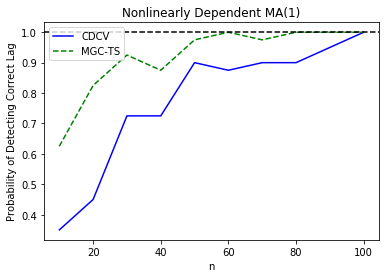

In [43]:
# Experimental parameters.
sample_sizes  = range(10,110,10)
num_sims      = 40
num_bootstrap = 100
alpha         = 0.05
maxlag        = 2

cdcv   = CDCV(max_lag = maxlag)
mgc_ts = MGC_TS(max_lag = maxlag)

powers_cdcv   = np.zeros(len(sample_sizes))
powers_lb     = np.zeros(len(sample_sizes))
powers_mgc_ts = np.zeros(len(sample_sizes))
probs_cdcv    = np.zeros(len(sample_sizes))
probs_mgc_ts  = np.zeros(len(sample_sizes))

sims = [
    #indep_ar1, 
    #lin_dep_ar1, 
    nonlin_dep_ma1
]
sim_names = [
    #"Independent AR(1)", 
    #"Correlated AR(1)", 
    "Nonlinearly Dependent MA(1)"
]

# For each simulated process:
for s in range(len(sims)):
    sim_type = sims[s]
    for i in range(len(sample_sizes)):
        rejects_cdcv   = 0.0
        rejects_lb     = 0.0
        rejects_mgc_ts = 0.0
        detects_cdcv   = np.zeros(num_sims)
        detects_mgc_ts = np.zeros(num_sims)
        n = sample_sizes[i]
        print("Estimating power/detection prob. at sample size: ", str(n), end = "")
        
        # Simulate time series and count rejections.
        for t in range(num_sims):
            print('.', end='')
            X, Y = sim_type(n)
            
            # CDCV
            CDCV_statistic, metadata = cdcv.test_statistic(X, Y)
            #p_value, _ = cdcv.p_value(X, Y, replication_factor = num_bootstrap)
            #if p_value < alpha:
            #    rejects_cdcv += 1
            detects_cdcv[t] = metadata['optimal_lag']
            
            # MGC TS
            MGC_TS_statistic, metadata = mgc_ts.test_statistic(X, Y)
            #p_value, _ = mgc_ts.p_value(X, Y, replication_factor = num_bootstrap, is_fast = False)
            #if p_value < alpha:
            #    rejects_mgc_ts += 1
            detects_mgc_ts[t] = metadata['optimal_lag']
                
            # Ljung-Box
            if ljung_box(X, Y, maxlag, alpha):
                rejects_lb += 1
        
        powers_cdcv[i]   = rejects_cdcv/num_sims
        powers_lb[i]     = rejects_lb/num_sims
        powers_mgc_ts[i] = rejects_mgc_ts/num_sims
        probs_cdcv[i]    = len(detects_cdcv[np.where(detects_cdcv == 0)])/num_sims
        probs_mgc_ts[i]  = len(detects_mgc_ts[np.where(detects_mgc_ts == 0)])/num_sims
        print("")
        
    # Display power estimates and probility of detecting the correct lag.
    #power_curve(sample_sizes, powers_cdcv, powers_lb, powers_mgc_ts, alpha, sim_names[s])
    optimal_lag_curve(sample_sizes, probs_cdcv, probs_mgc_ts, sim_names[s])

(array([ 0., 40.,  0.]),
 array([-0.5       , -0.16666667,  0.16666667,  0.5       ]),
 <a list of 3 Patch objects>)

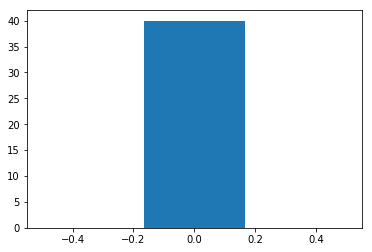

In [39]:
plt.hist(detects_cdcv, bins = 3)

(array([ 0., 40.,  0.]),
 array([-0.5       , -0.16666667,  0.16666667,  0.5       ]),
 <a list of 3 Patch objects>)

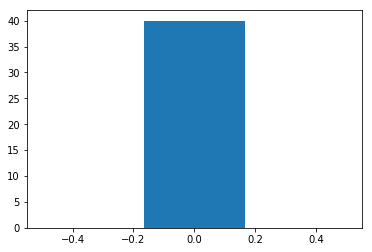

In [40]:
plt.hist(detects_mgc_ts, bins = 3)